# Introduction
The 2023 Kidney and Kidney Tumor Segmentation Challenge

## Motivation


## Problem Statement


# Imports python modules
- below gives list of modules used

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import sys
import re
import os
import torch.optim as optim
import time
import nibabel as nib
import matplotlib.pylab as plt
import math
from torch.utils.data import DataLoader
from tqdm import tqdm
from nilearn.image import resample_img
from scipy import ndimage
from datetime import datetime
from glob import glob

In [2]:
# !pip install onnx

In [3]:
base_dir = "./"
raw_dataset_dir = "dataset/"
transformed_dataset_dir_path = "dataset/affine_transformed/"

## Dataset folder setup check
- below is to check if dataset folder and preprocessed dataset folder exists

In [4]:
is_colab = False
if is_colab:
    base_dir = "/content/drive/MyDrive/Colab Notebooks/"
    if not os.path.isdir(base_dir):
        from google.colab import drive
        drive.mount('/content/drive')
        
raw_dataset_dir = os.path.join(base_dir, raw_dataset_dir)
transformed_dataset_dir_path = os.path.join(base_dir, transformed_dataset_dir_path)
    
if os.path.isdir(raw_dataset_dir) and os.path.isdir(transformed_dataset_dir_path):
    print("dataset folder exists, OK")
else:
    raise Exception("check path for dataset:{} \n path for transformed dataset: {}"
                    .format(raw_dataset_dir, transformed_dataset_dir_path))


dataset folder exists, OK


# Data Sources
- Data sources is for Kits-23 challenge and information can be found at https://kits-challenge.org/.
- Dataset can be downloaded as tar and extract at dataset folder.
- Note: Data is required at dataset folder to enable
-- the view of dataset (visualisation of dataset)
-- pre-process / transform the dataset (to smaller sze)



In [5]:
raw_train_images_path = os.path.join(raw_dataset_dir,'case_00???/imaging.nii.gz')
raw_segmentation_images_path = os.path.join(raw_dataset_dir,'case_00???/segmentation.nii.gz')
raw_train_images = sorted(glob(raw_train_images_path))
raw_segmentation_images = sorted(glob(raw_segmentation_images_path))

if len(raw_train_images) > 2 and len(raw_segmentation_images) > 2:
    print("data exists, OK")
else:
    raise Exception("No data is found at dataset folder {} or segmentation folder {}".format(train_images_path,segmentation_images_path))

data exists, OK


## Challenges
- The images are stored in "nii.gz" format. The size of the images are large and hard to process.
- There are 489 cases availble. These cases have segmented data available. Relatively, large amount of dataset is available.
- Need to understand basic shape of the data
- The number of classes in the dataset need to be verified.


### Visulisation of Dataset
 Get the shape of the images to understand how the 3D images are stored
-It is found that(layers, pixels, pixels) or known as (z, y, x):
- For case 0: (611, 512, 512)
- For case 2: (261, 512, 512)
> 3D cases have different layers!!


In [6]:
case_index = 0
case_index2 = 2
img_path = raw_train_images[case_index]
img_loader = nib.load(img_path)
img = img_loader.get_fdata()
print("index={}, path= {} \n shape of image = {} with type {}\n"
      .format(case_index, img_path, img.shape, type(img)))

img_path2 = raw_train_images[case_index2]
img2_loader = nib.load(img_path2)
img2 = img2_loader.get_fdata()
print("index={}, path= {} \n shape of image = {} with type {}"
      .format(case_index2, img_path, img2.shape, type(img2)))

index=0, path= ./dataset/case_00000/imaging.nii.gz 
 shape of image = (611, 512, 512) with type <class 'numpy.ndarray'>

index=2, path= ./dataset/case_00000/imaging.nii.gz 
 shape of image = (261, 512, 512) with type <class 'numpy.ndarray'>



#### Plot the Layers of Case 0




In [7]:
square_num = 6
factor = img.shape[0] // (square_num**2)
print("number of layers to be shown = {}".format(square_num**2))

number of layers to be shown = 36


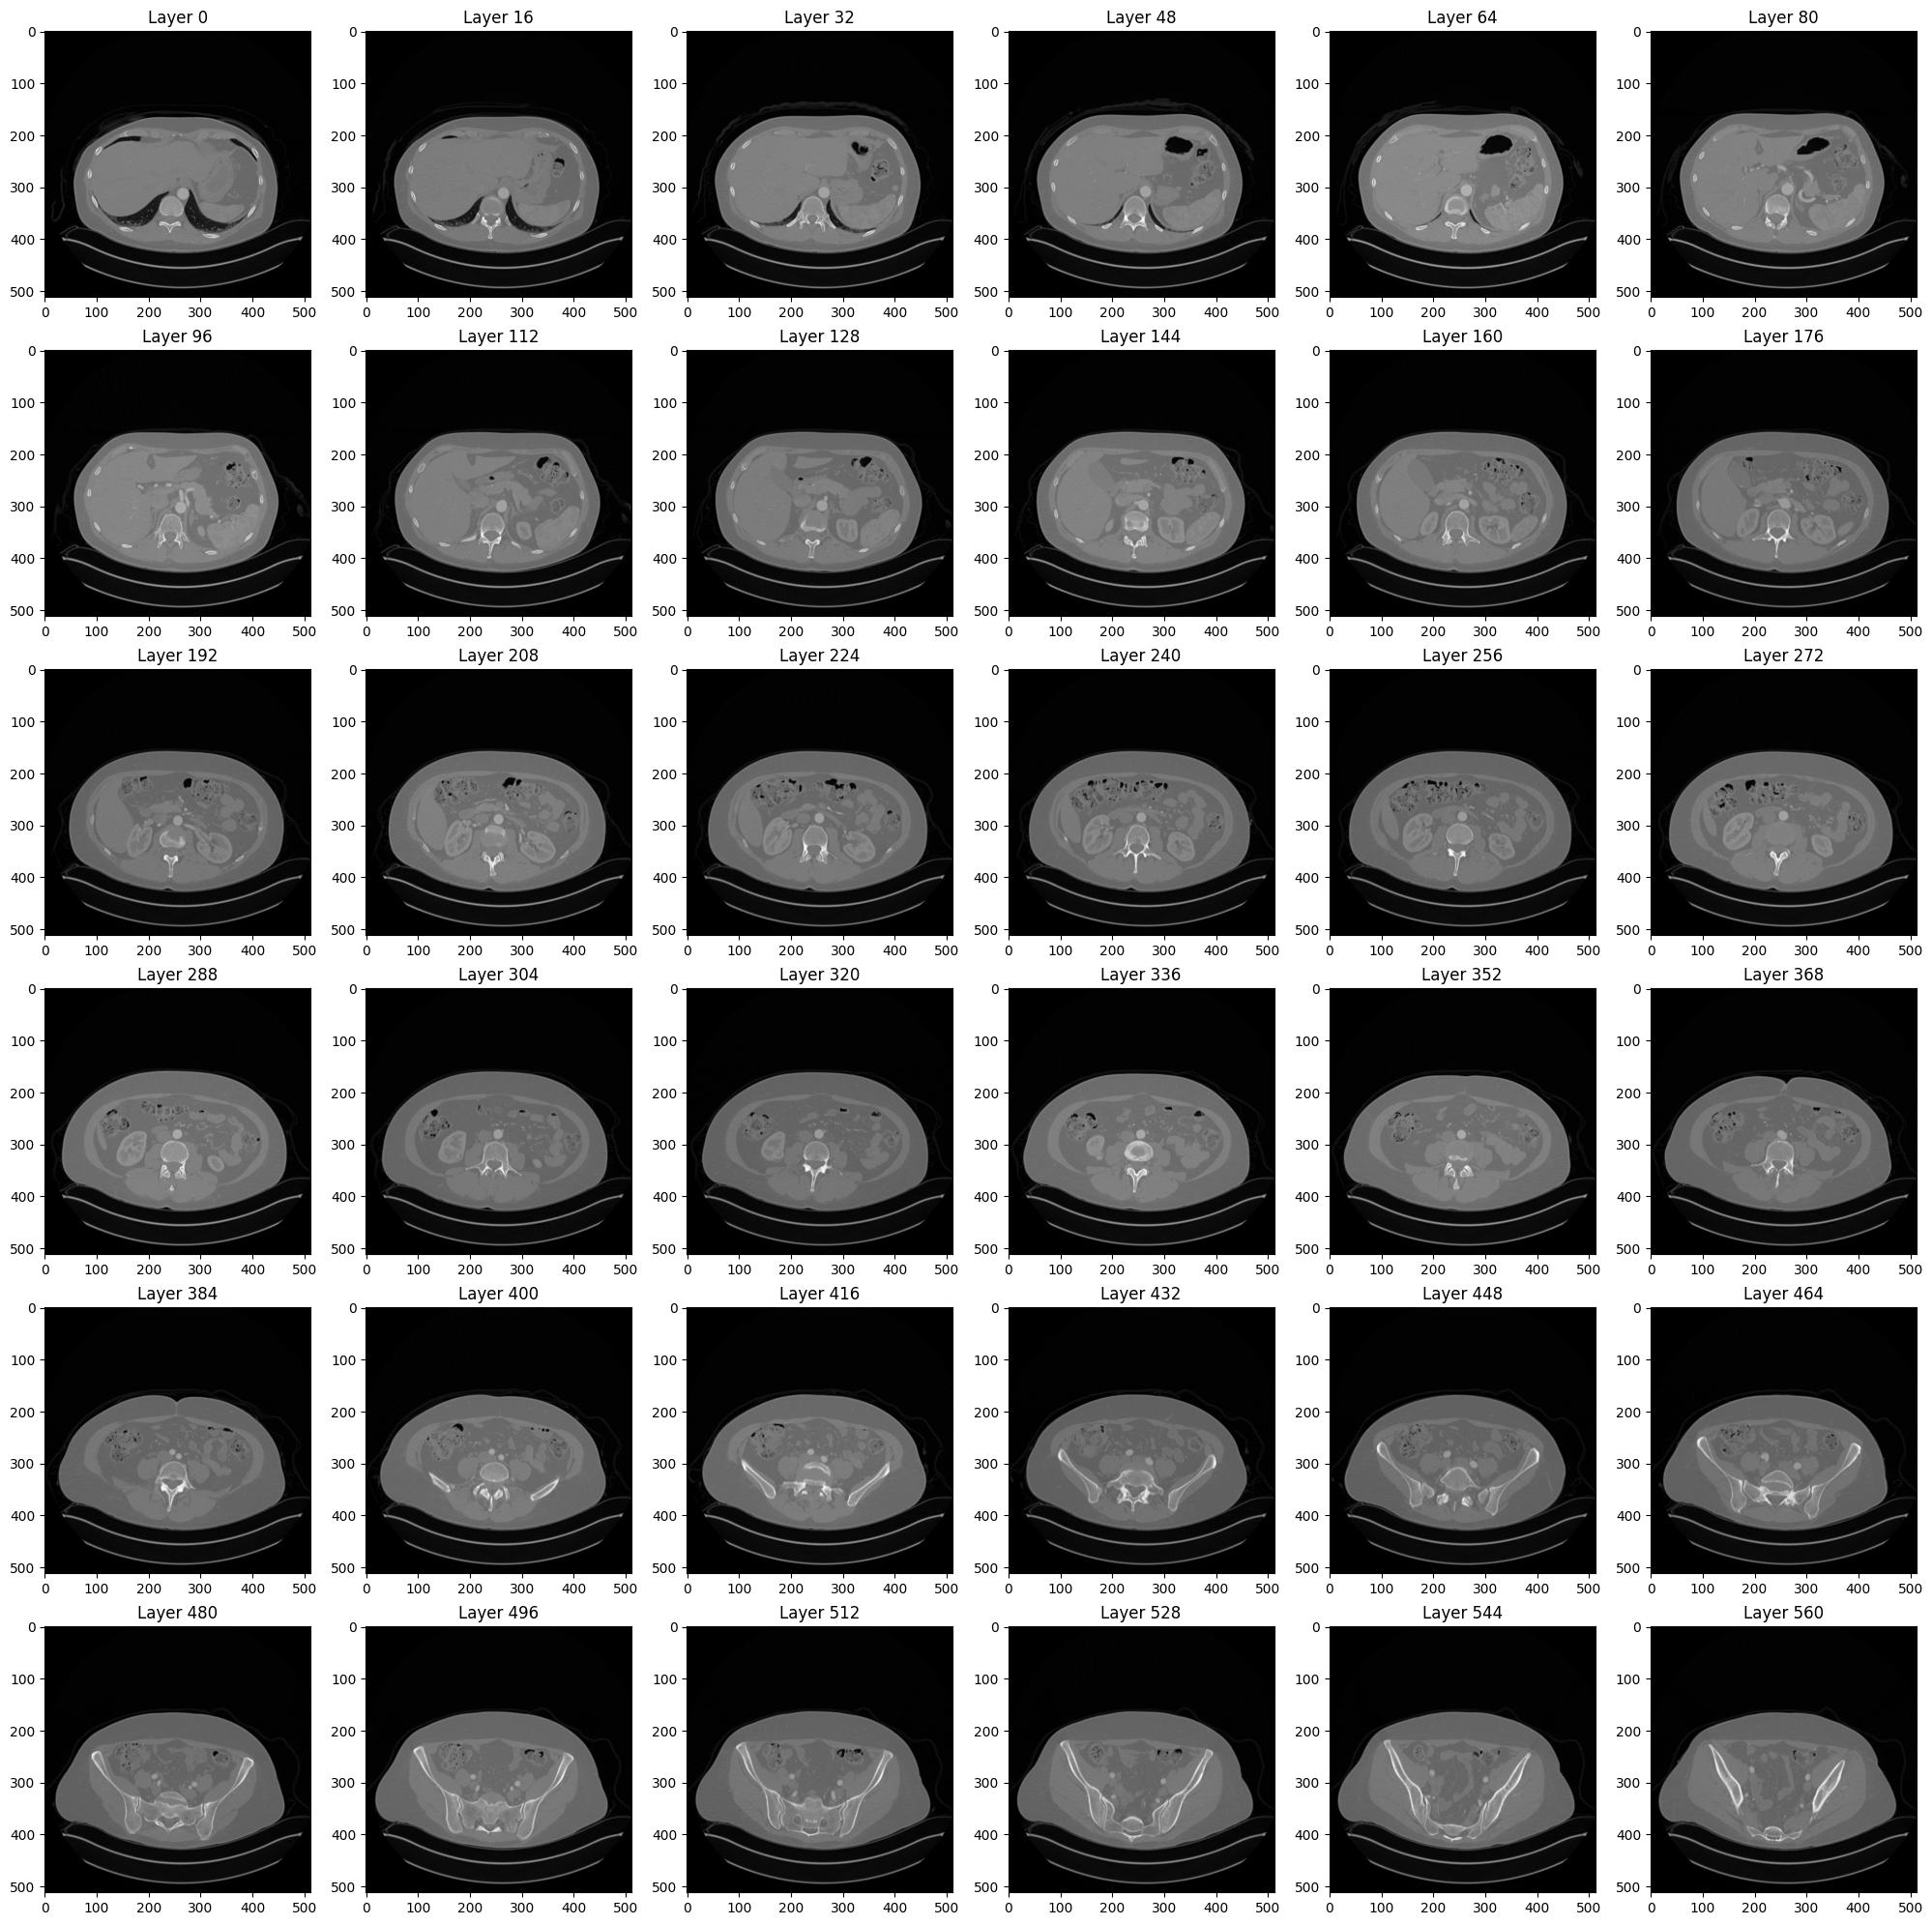

In [8]:
plt.style.use('default')
fig, axes = plt.subplots(square_num,square_num, figsize=(25,25))
for i, ax in enumerate(axes.reshape(-1)):
    ax.title.set_text(f'Layer {i*factor}')
    ax.imshow(img[i*factor,:,:],cmap="gray")
plt.show()

### Check Segmentation Layers
- This is to check how classes are labeled and/or captured. From kits23 challeges, it is known that classes are Kidney, Tumor and Cyst.
- As below is to view 3D Images in planer view, it could fail to show label that is only appears at few layers.
- Numpy unique is used to check clasess/labels.

In [9]:
seg_img_path= raw_segmentation_images[case_index]
seg_img = nib.load(seg_img_path).get_fdata()
seg_img_path2= raw_segmentation_images[case_index2]
seg_img2 = nib.load(seg_img_path2).get_fdata()
print("index={} shape of image = {} with type {}".format(case_index, seg_img.shape, type(seg_img)))
print("index={} shape of image = {} with type {}".format(case_index2, seg_img2.shape, type(seg_img2)))

index=0 shape of image = (611, 512, 512) with type <class 'numpy.ndarray'>
index=2 shape of image = (261, 512, 512) with type <class 'numpy.ndarray'>


#### Determine Classes in Segmentation Layers
- From context, it is known to be segmented to 4 classes, which are Kidney, Cyst and Tumor
- Kidney = 1
- Tumor = 2
- Cyst = 3
- None of above = 0

In [10]:
print("Index={}, seg_path={} \nClass labels = {} ".format(case_index, seg_img_path, np.unique(seg_img)))
print("\n")
print("Index={}, seg_path={} \nClass labels = {} ".format(case_index2, seg_img_path2, np.unique(seg_img2)))

Index=0, seg_path=./dataset/case_00000/segmentation.nii.gz 
Class labels = [0. 1. 2.] 


Index=2, seg_path=./dataset/case_00002/segmentation.nii.gz 
Class labels = [0. 1. 2. 3.] 


#### Case_00000 and case_000002
- From [Kits-23 Challenge](http://kits-challenge.org) , the dataset information confirms the labels for both cases, where case_00000 has no Cyst, label 3.
- ![alt AFFINE MATRIX](./notebook_imgs/case_00000_case_00002.png)

#### Show Image of Kidney label
- At last step, it demonstrates that case 0 has no Cyst label
- Kidneys are large and can be found at many layers

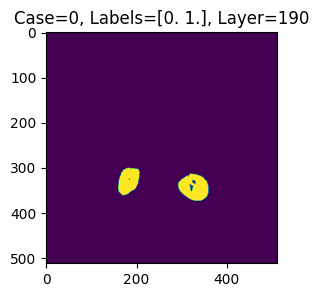

In [11]:
this_layer = 190
plt.style.use('default')
fig, axes = plt.subplots(figsize=(3,3))
axes.imshow(seg_img[this_layer,:,:])
axes.set_title(f"Case={case_index}, Labels={np.unique(seg_img[190,:,:])}, Layer={this_layer}")
plt.show()

#### Inspecting Segmentation Imagers Layers and Labels (for Tumor)
- below is to confirm tumor label exists in the dataset.

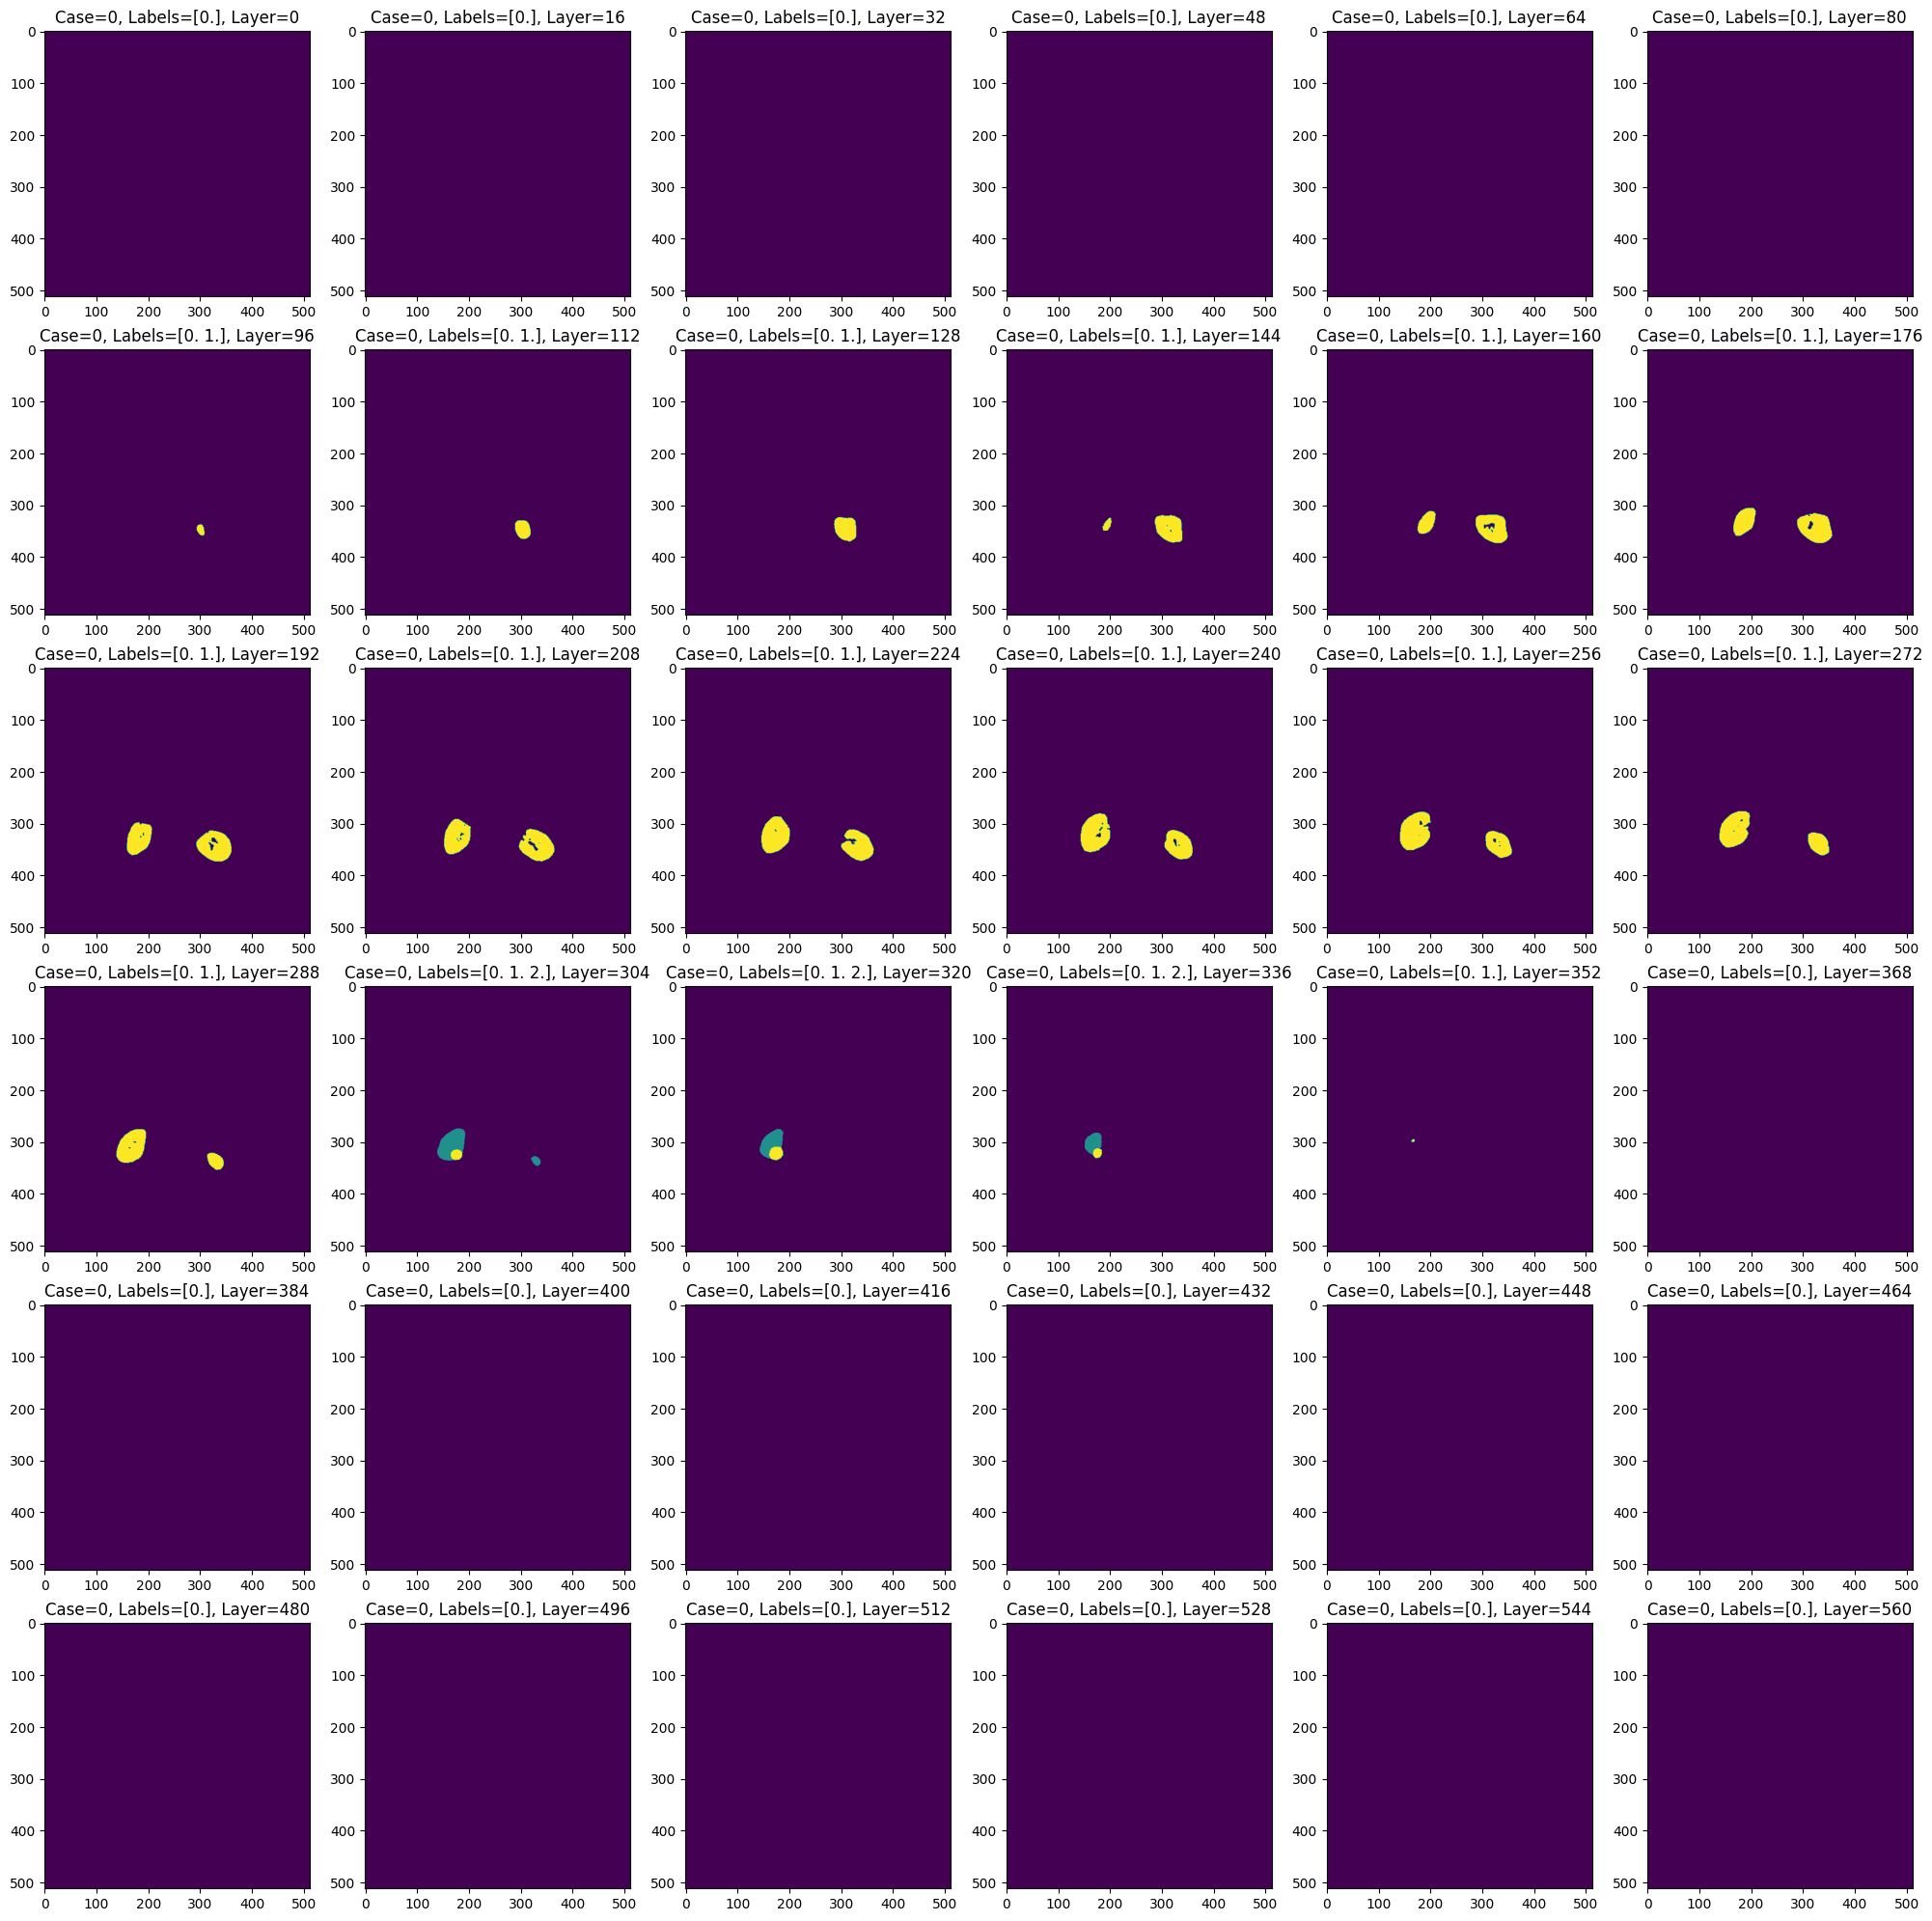

In [12]:
plt.style.use('default')
fig, axes = plt.subplots(square_num,square_num, figsize=(25,25))
for i, ax in enumerate(axes.reshape(-1)):
    this_layer = i*factor
    ax.title.set_text(f"Case={case_index}, Labels={np.unique(seg_img[this_layer,:,:])}, Layer={this_layer}")
    ax.imshow(seg_img[i*factor,:,:])
plt.show()

## Preprocess
- Case visualisation determines that each case or each 3D-images has different number layers.
- These raw dataset are required to transform the 3D-images to uniform dataset.
- Also, due to limitation on computation power and time, it is preferbly to reduce resolution of the 3D-images.
- Strategies that have been adapted are image padding, image clipping and affine transform


### Image padding
- When padding is required for input images, -1024 will be assigned for the padding of the voxel space. This is because the minimum value for the voxel space is -1024.
- For segmentation images, padding value of 0, which represents the background, will be assigned.



### Image clipping
- Voxel space that is not within target shape is clipped. More information can be found at below.

-- https://nilearn.github.io/dev/modules/generated/nilearn.image.resample_img.html#nilearn.image.resample_img

### Affine Transform
- By inspection of data, it has been found that 3D images have different affine setting.
- Due to different in Voxel Spacing, data is transformed to uniform space.
- Also, to reduce the 3D images resolution, it is determined that 3D images are required to be scaled up.
- This can also be described that dataset has different affine setting.



#### Affine Matrix
- Below give general information about affine matrix for 3D volume/perspective transformation.
- It is important to note that dataset used in this project has matrix represented in (z, y, x).
- ![alt AFFINE MATRIX](./notebook_imgs/affine_img.png "Title")

### Inspect affine matrix
- For example, below is to compare case 0 and case 2. Voxel spacing of case 0 is smaller than 2, especially in the z layer, which are 0.5 and 1 respectively.
- To save space, higher voxel spacing is to be used. In Kit19, from https://github.com/jchen42703/kits19-cnn/tree/master, has used target_spacing=(3.22, 1.62, 1.62),
- This project has used target_spacing=(2, 2, 2)

In [13]:
target_affine_space = np.array(([0, 0, -2, 0],[0, -2, 0, 0],[-2, 0, 0, 0],[0, 0, 0, 1]))
target_shape = (128, 232, 232)

In [14]:
train_images = sorted(glob("./dataset/affine_transformed/case_00???/imaging.nii.gz"))
segmentation_images = sorted(glob("./dataset/affine_transformed/case_00???/segmentation.nii.gz"))


In [15]:
case0 = 0
case2 = 2
raw_img_case0_loader = nib.load(raw_train_images[case0])
raw_img_case2_loader = nib.load(raw_train_images[case2])
print("Raw form -> case {} with shape {} has affine: \n{}".format(case0, raw_img_case0_loader.shape, raw_img_case0_loader.affine))
print("Raw form -> case {} with shape {} has affine: \n{}".format(case2, raw_img_case2_loader.shape, raw_img_case2_loader.affine))
resampled_case0_loader = resample_img(raw_img_case0_loader, target_affine=target_affine_space, target_shape=target_shape, interpolation='nearest', fill_value=-1024)
resampled_case2_loader = resample_img(raw_img_case2_loader, target_affine=target_affine_space, target_shape=target_shape, interpolation='nearest', fill_value=-1024)
print("After transform -> case {} with shape {} has affine: \n{}".format(case0,resampled_case0_loader.shape, resampled_case0_loader.affine))
print("After transform -> case {} with shape {} has affine: \n{}".format(case2, resampled_case2_loader.shape, resampled_case2_loader.affine))

Raw form -> case 0 with shape (611, 512, 512) has affine: 
[[ 0.          0.         -0.91992188  0.        ]
 [ 0.         -0.91992188  0.          0.        ]
 [-0.5         0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Raw form -> case 2 with shape (261, 512, 512) has affine: 
[[ 0.          0.         -0.93945312  0.        ]
 [ 0.         -0.93945312  0.          0.        ]
 [-1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
After transform -> case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]
After transform -> case 2 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


In [16]:
img_case0 = raw_img_case0_loader.get_fdata()
img_case0_resampled = resampled_case0_loader.get_fdata()
img_case2 = raw_img_case2_loader.get_fdata()
img_case2_resampled = resampled_case2_loader.get_fdata()

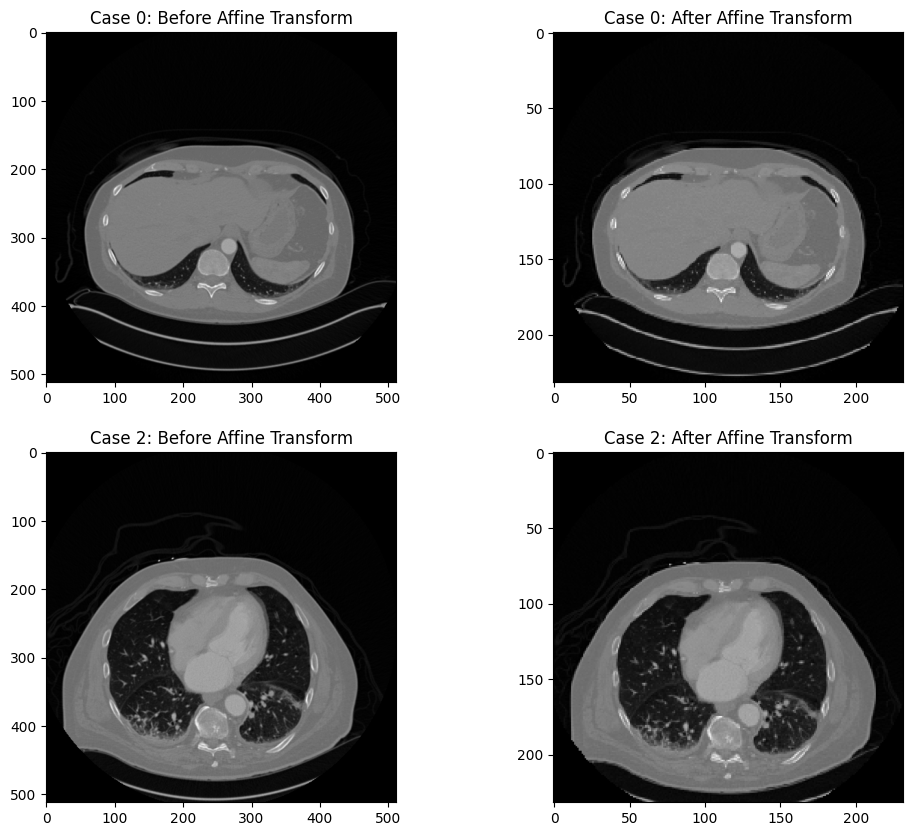

In [17]:
this_layer = 0
plt.style.use('default')
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes[0,0].imshow(img_case0[this_layer,:,:], cmap="gray")
axes[0,0].title.set_text(f'Case {case0}: Before Affine Transform')
axes[0,1].imshow(img_case0_resampled[this_layer,:,:], cmap="gray")
axes[0,1].title.set_text(f'Case {case0}: After Affine Transform')
axes[1,0].imshow(img_case2[this_layer,:,:], cmap="gray")
axes[1,0].title.set_text(f'Case {case2}: Before Affine Transform')
axes[1,1].imshow(img_case2_resampled[this_layer,:,:], cmap="gray")
axes[1,1].title.set_text(f'Case {case2}: After Affine Transform')
# axe.set_title(f"Case={case_index}, Labels={np.unique(seg_img[190,:,:])}, Layer={this_layer}")
plt.show()

### Loss of Segmentation Data from scaling/downsample (Data Augmentation)
The root cause of losing segmentaiton are given at below
- With the chosen affine matrix, some 3D images may scale down or zoom out. 
- In addition, the 3D space is to be adapted with lower resolution
- Data augmentation is topic to be considered in the future.

Below has given case 8, that has lost segmentation labels after affine transform. It scale down in z layer, and scale up in x and y axes.

In [18]:
for i in range(7,9):
    raw_seg_image_path_uniq = raw_segmentation_images[i]
    seg_img_path_uniq = segmentation_images[i]
    seg_img_uniq_loader = nib.load(seg_img_path_uniq)
    raw_seg_img_uniq_loader = nib.load(raw_seg_image_path_uniq)
    seg_img_uniq = seg_img_uniq_loader.get_fdata()
    raw_seg_img_uniq = raw_seg_img_uniq_loader.get_fdata()
    
    print("Raw case {}, unique={}".format(i, np.unique(raw_seg_img_uniq)))
    print("Transformed case {}, unique={}".format(i, np.unique(seg_img_uniq)))
    print("Raw case 0 with shape {} has affine: \n{}".format(raw_seg_img_uniq_loader.shape, raw_seg_img_uniq_loader.affine))
    print("Transformed case 0 with shape {} has affine: \n{}".format(seg_img_uniq_loader.shape, seg_img_uniq_loader.affine))
    
    print("==="*10)

Raw case 7, unique=[0. 1. 2.]
Transformed case 7, unique=[0. 1. 2.]
Raw case 0 with shape (61, 512, 512) has affine: 
[[ 0.          0.         -0.93945312  0.        ]
 [ 0.         -0.93945312  0.          0.        ]
 [-3.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Transformed case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]
Raw case 8, unique=[0. 1. 2. 3.]
Transformed case 8, unique=[0.]
Raw case 0 with shape (227, 512, 512) has affine: 
[[ 0.          0.         -0.81640625  0.        ]
 [ 0.         -0.81640625  0.          0.        ]
 [-3.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]
Transformed case 0 with shape (128, 232, 232) has affine: 
[[ 0.  0. -2.  0.]
 [ 0. -2.  0.  0.]
 [-2.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


### Preprocess to transform all dataset to target affine space
- This enable consistent voxel space for analysis
- In general, voxel space is downsampled, this will save process time.
- See notebook resample_dataset.ipynb to resample all dataset

# Neural Network for 3D Images Segmentation
This problem is 3D volume segmentation. Popular neural network for the task are listed below
- FCN (fully convolutional network - eg: Resnet - using 3D/2D convolution
- UNET (with skip connection using 3D/2D convolution)
- nnU-Net (multiple UNETs) 

- Interesting topic includes convolution-free image segmentation using transformer (future works, time constraint has prevented further study) https://arxiv.org/abs/2203.16768



## FCN - 3D Resnet
- In most problems, Resnet can only achieve 60-70% accuracy, which can be seen at https://github.com/Tencent/MedicalNet.
- However, this MedicalNet pretrain has achieve LungSeg(Dice) at approximately 90%.
- Therefore, the team has decided to invest time to study the design.

> @article{chen2019med3d,
        title={Med3D: Transfer Learning for 3D Medical Image Analysis},
        author={Chen, Sihong and Ma, Kai and Zheng, Yefeng},
        journal={arXiv preprint arXiv:1904.00625},
        year={2019}
    }


## 3DResnet - Imports
- import model generator
- import helper functions (reduce messy codes in notebook)
- helper function can split training and testing data
- helper function can generate torch compatible dataloader

In [19]:
from classes.dataset_utils.toTorchDataset import ProcessedKit23TorchDataset
from classes.models import resnet_model_generator
from classes.config_class import ProjectModelResnetConfig
from classes.epoch_results import EpochResult

In [20]:
training_data = ProcessedKit23TorchDataset(train_data=True, test_size=0.25, dataset_dir ="./dataset/affine_transformed")
test_data = ProcessedKit23TorchDataset(train_data=False, test_size=0.25, dataset_dir ="./dataset/affine_transformed")
print("size of training data:{}    size of testing dat:{}".format(len(training_data), len(test_data)))

size of training data:367    size of testing dat:122


## Modifying Tail for the Network (and select RESNET layers)
- A helper function is written to modify the tail of the model.
- network can be printed to confirm that tail is modified to 4 classes.
- Resnet 10 or 50 can be selected here

In [21]:
proj_config = ProjectModelResnetConfig(model_depth=10, no_cuda = True, n_seg_classes=4)
proj_resnet_model, _ = resnet_model_generator.generate_model(proj_config)
proj_config.set_net_model(proj_resnet_model)

In [22]:
# print(proj_resnet_model)

## Settign SGD optimizer with Learning Rate Scheduler
- SGD has been chosen as optimiser. Adam would be the next candidate if time is availale.
- Learning rate is to have exponential learning rate decay.

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(proj_config.nn_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
if not proj_config.no_cuda:
    criterion = criterion.cuda()

## Load Final Trained Weight
- resnet_traing.ipynb provides evidence of training.
- both resnet10 and resnet50 are trained
- for loading Med3D pretrain weight, see classes/config_class.py -> ProjectModelResnetConfig.load_med3d_pretrain_weigth

In [24]:
train_from_pretrained = True
epoch_res = EpochResult()
epoch_start = 0
if train_from_pretrained:
    print("loading from pretrained Med3D model")
    if proj_config.model_depth == 10:
        checkpoint, epoch_res = proj_config.load_weight_from_epoch("./training_checkpoints/Model_resnet_10_epoch10.pth.tar")
    elif proj_config.model_depth == 50:
        checkpoint, epoch_res = proj_config.load_weight_from_epoch("./training_checkpoints/Model_resnet_50_epoch3.pth.tar")
    else:
        raise Exception("Only depth 10 and 50 are used for now.")
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = epoch_res.epoch_list[-1] + 1
else:
    # this continues from certain training points
    # checkpoint, epoch_res = proj_config.load_weight_from_epoch("./training_checkpoints/Model_resnet_50_epoch3.pth.tar")
    # optimizer.load_state_dict(checkpoint['optimizer'])
    # epoch_start = epoch_res.epoch_list[-1] + 1
    raise Exception("Only trained weight is loaded.")
    
 

loading from pretrained Med3D model
./training_checkpoints/Model_resnet_10_epoch10.pth.tar


In [25]:
data_loader = DataLoader(test_data, batch_size=proj_config.batch_size, shuffle=False, num_workers=proj_config.num_workers, pin_memory=proj_config.pin_memory)

In [26]:
def visual_3d(input_img):
    square_num = 6
    factor = input_img.shape[0] // (square_num**2)
    print("number of layers to be shown = {}".format(square_num**2))
    plt.style.use('default')
    fig, axes = plt.subplots(square_num,square_num, figsize=(25,25))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.title.set_text(f'Layer {i*factor}')
        ax.imshow(input_img[i*factor,:,:])
    plt.show()

In [27]:
masks = []
proj_config.nn_model.eval()
for batch_id, batch_data in enumerate(data_loader):
    imgs, segs = batch_data
    if not proj_config.no_cuda:
        imgs = imgs.cuda()
    with torch.no_grad():
        probs = proj_config.nn_model(imgs.float())
        outputs = F.softmax(probs, dim=1)
        # resize mask to original size
    batchsize, _, mask_d, mask_h, mask_w = outputs.shape
    batchsize, _, depth, height, width = imgs.shape
    scale = [1, depth*1.0/mask_d, height*1.0/mask_h, width*1.0/mask_w]
    # loop through batch size
    for i, img in enumerate(imgs):
        output = outputs[i]
        # scale only z, y, x
        output = ndimage.zoom(output, scale, order=1)
        masks.append(output)
    if batch_id % 10 == 0:
        print("current batch ID:{} with batch size={}".format(batch_id, batchsize))

current batch ID:0 with batch size=1
current batch ID:10 with batch size=1
current batch ID:20 with batch size=1
current batch ID:30 with batch size=1
current batch ID:40 with batch size=1
current batch ID:50 with batch size=1
current batch ID:60 with batch size=1
current batch ID:70 with batch size=1
current batch ID:80 with batch size=1
current batch ID:90 with batch size=1
current batch ID:100 with batch size=1
current batch ID:110 with batch size=1
current batch ID:120 with batch size=1


In [28]:
    # # evaluation: calculate dice 
    # label_names = [info.split(" ")[1] for info in load_lines(sets.img_list)]
    # Nimg = len(label_names)
    # dices = np.zeros([Nimg, sets.n_seg_classes])
    # for idx in range(Nimg):
    #     label = nib.load(os.path.join(sets.data_root, label_names[idx]))
    #     label = label.get_data()
    #     dices[idx, :] = seg_eval(masks[idx], label, range(sets.n_seg_classes))

## Exiting Neural Network

### Which part of the Neural Network will be freezed
### Design of neural network for the specific purpose